In [2]:
from Data_Processing.processing import extract_data
from Data_Processing.processing import cut_to_start
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
import math

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
sim1 = extract_data("Data/Param_Export_Example.xlsx")

In [5]:
data = cut_to_start(sim1)

# Fourier  Series

We will transform our singal into fourier series before training.

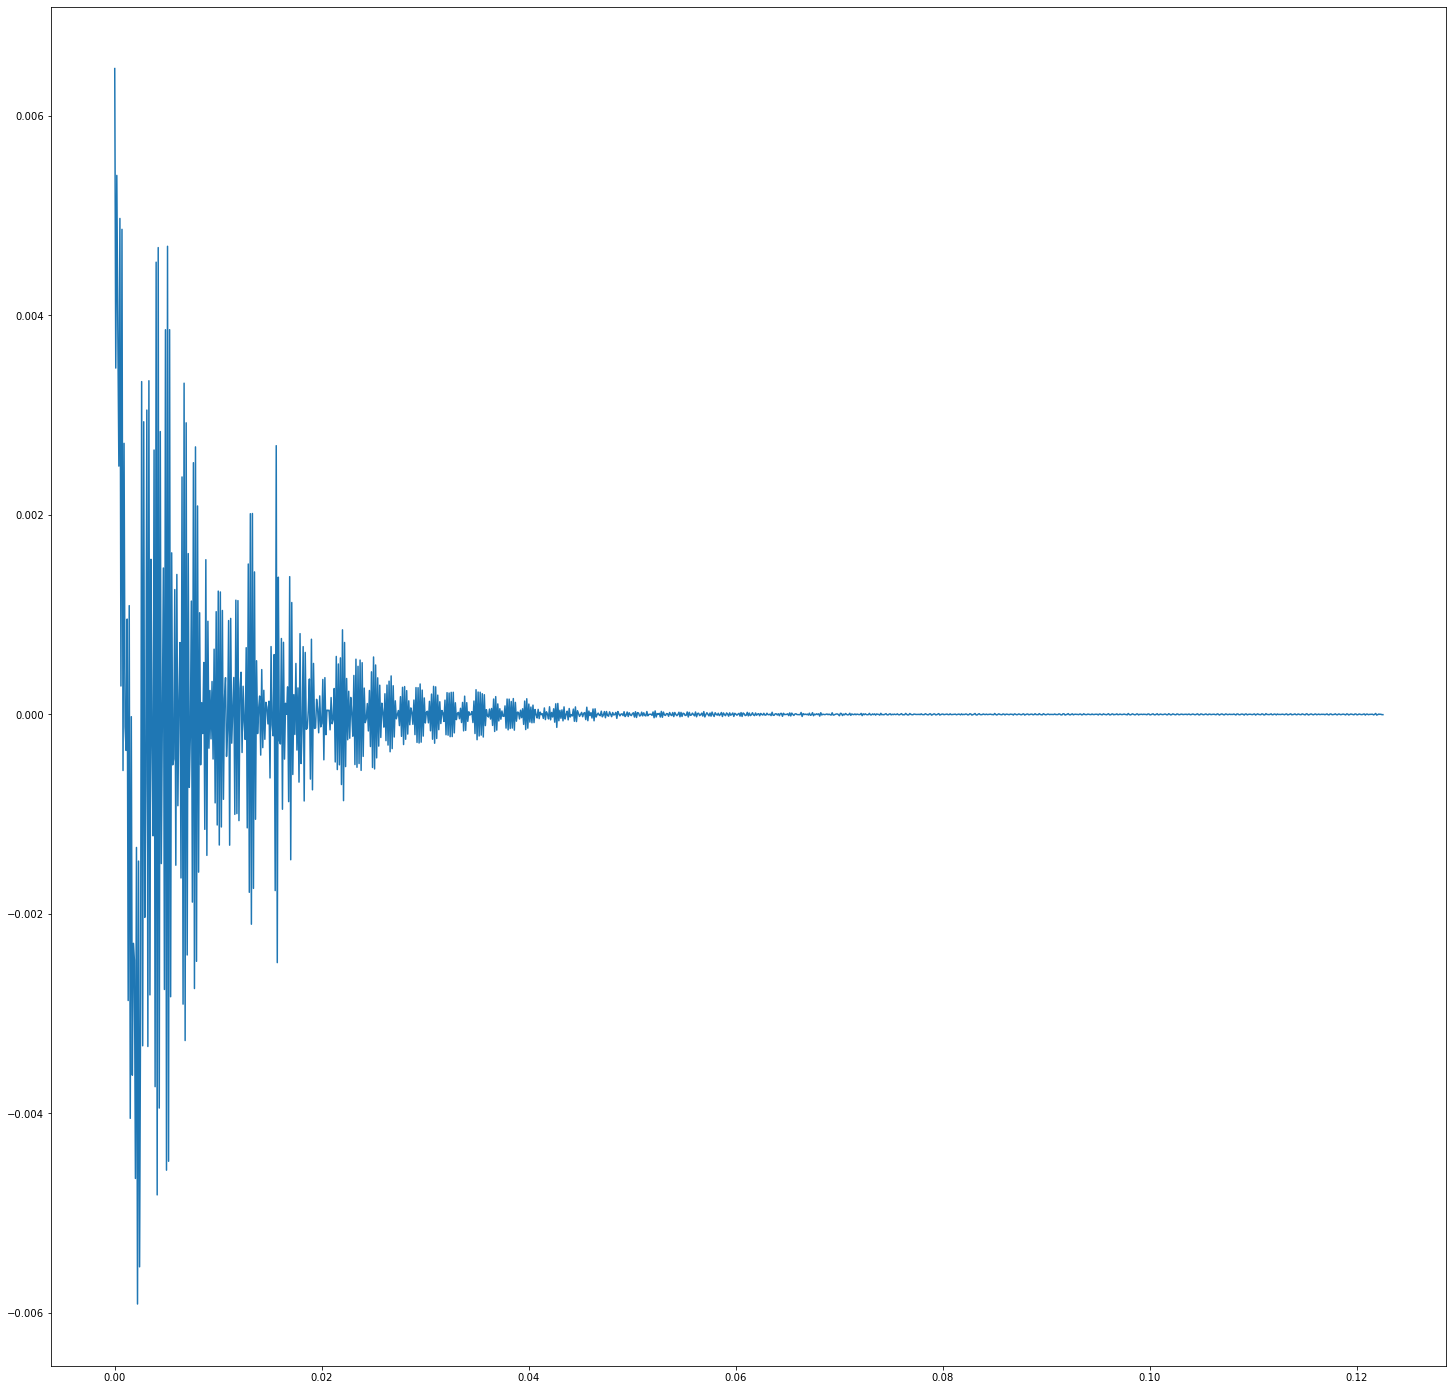

In [6]:
plt.figure(figsize=(25,25))
plt.plot(data["t"],data["v"])

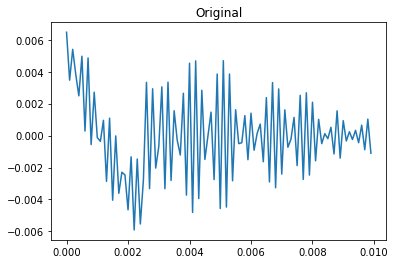

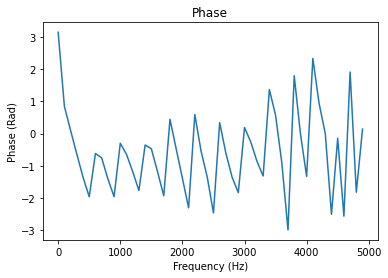

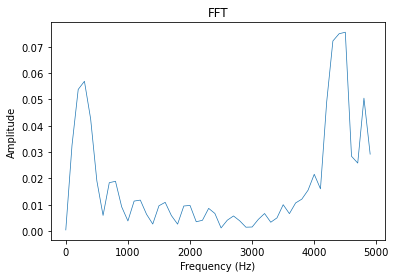

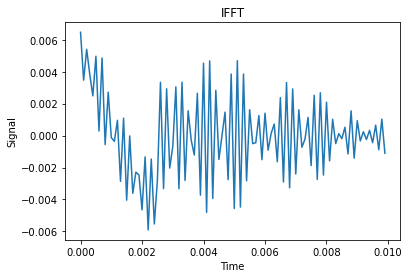

In [7]:
n = 100


plt.plot(data["t"][:n],data["v"][:n])
plt.title('Original')
plt.show()

signal = np.array(data["v"][:n])

time = np.array(data["t"][:n])

sampling_rate = round(1 / (time[1] - time[0]))  # Sampling rate
freq = np.fft.fftfreq(n, d=1/sampling_rate)

signal_fft = np.fft.fft(signal)
pos_freq = freq[:n//2]
phase = np.angle(signal_fft)
pos_phase = phase[:n//2]
plt.plot(pos_freq,pos_phase)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (Rad)')
plt.title("Phase")
plt.show()


pos_signal_fft = np.abs(signal_fft)[:n//2]
#print(signal_fft.real)
plt.plot(pos_freq, pos_signal_fft.real, linestyle='-', linewidth=0.7)
plt.title(f'FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
#plt.xlim(0, np.max(pos_freq))
plt.show()


recovered_signal = np.fft.ifft(signal_fft,n)
plt.plot(data["t"][:n],recovered_signal.real)
plt.title(f'IFFT')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()

We can see how Fourier series recreates our signal by adding 1 frequency at a time.

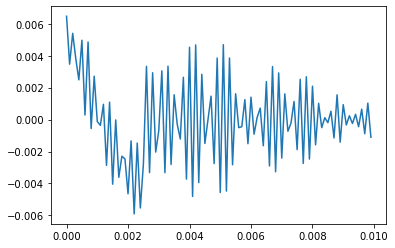

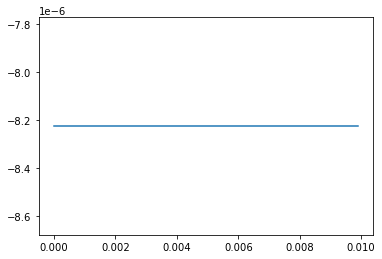

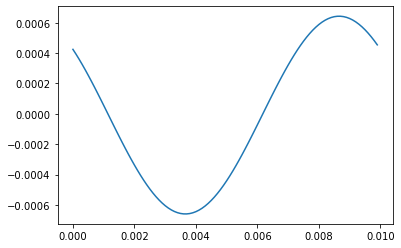

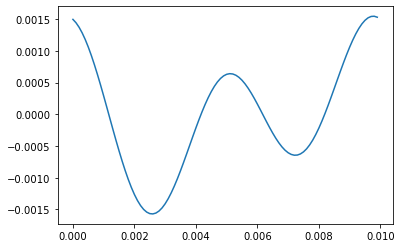

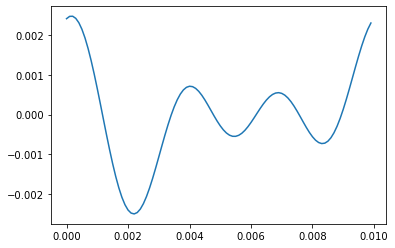

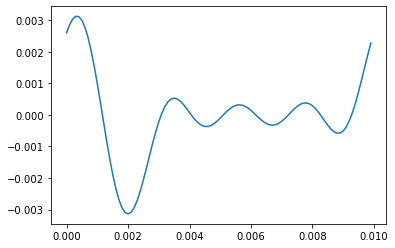

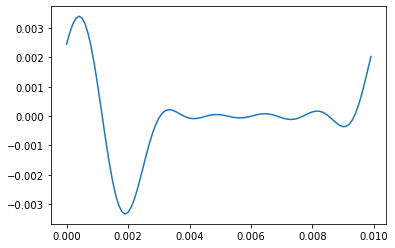

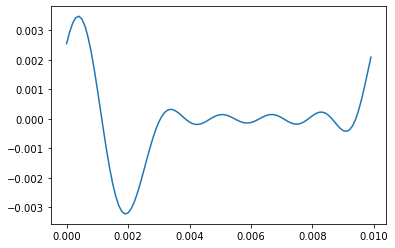

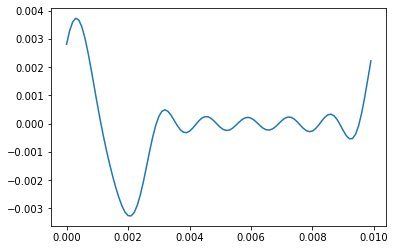

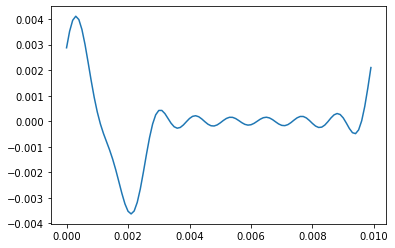

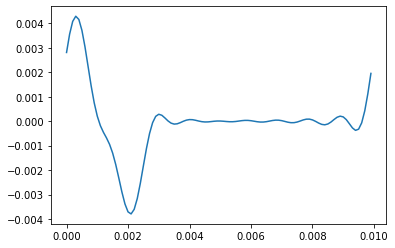

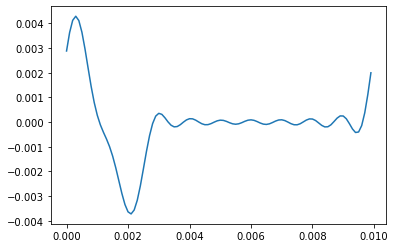

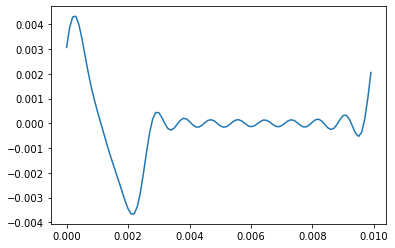

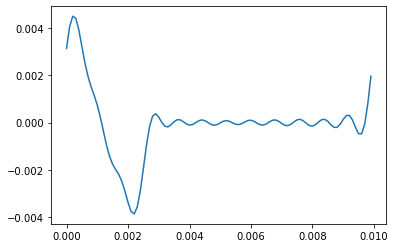

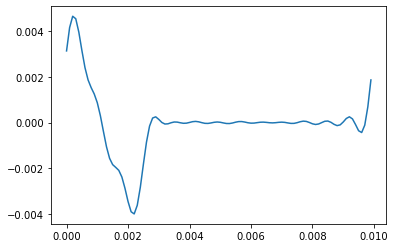

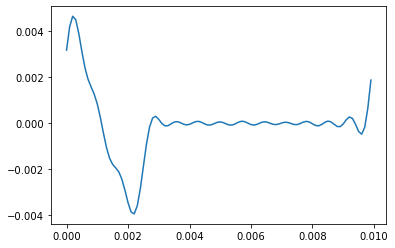

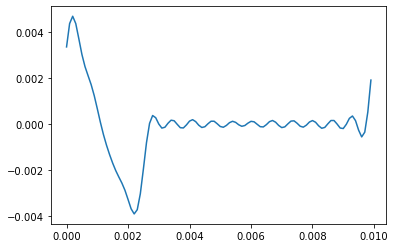

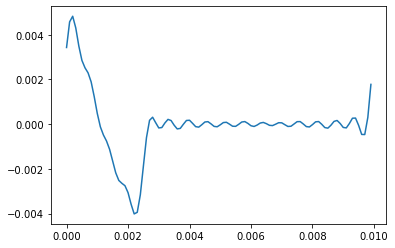

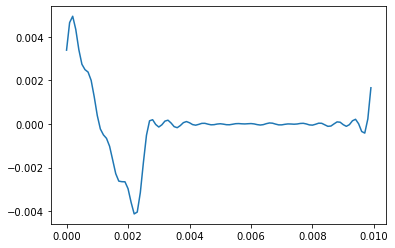

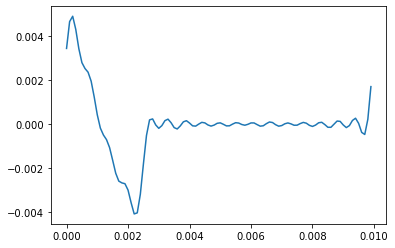

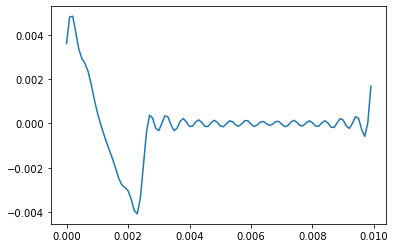

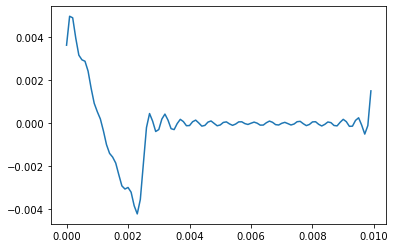

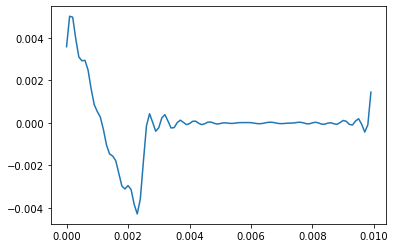

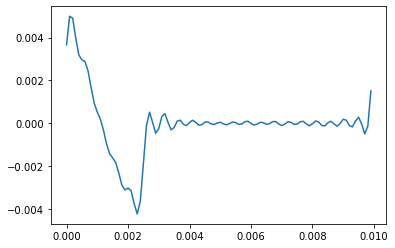

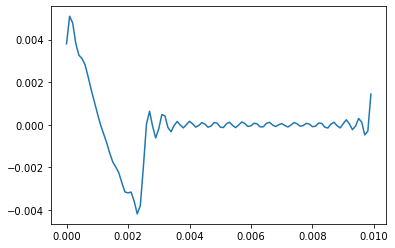

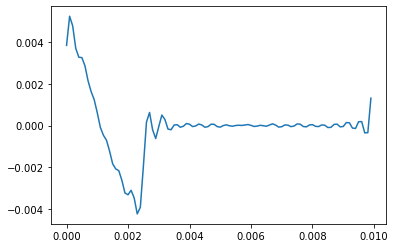

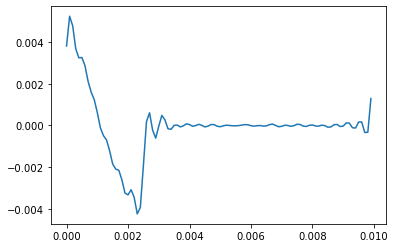

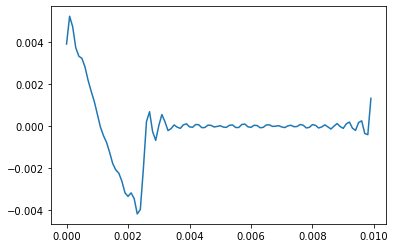

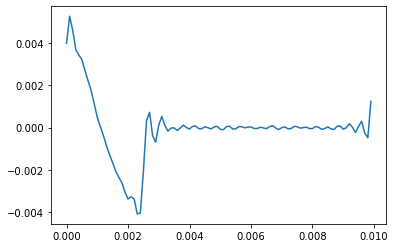

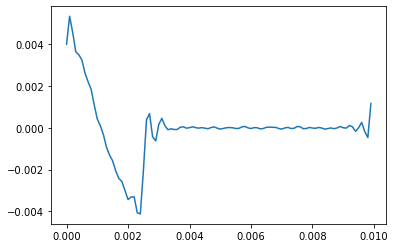

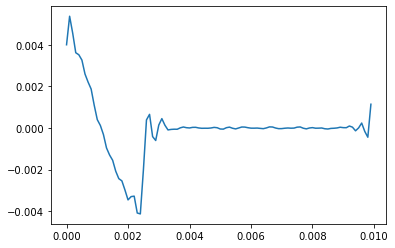

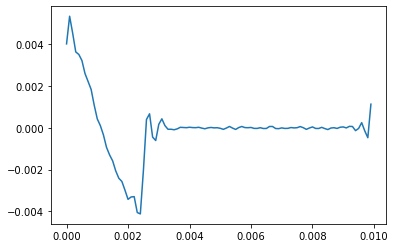

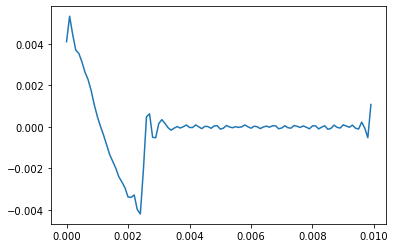

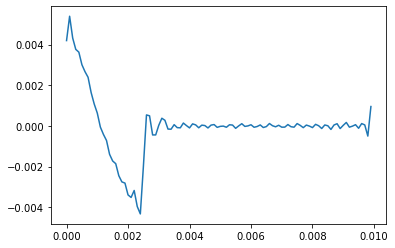

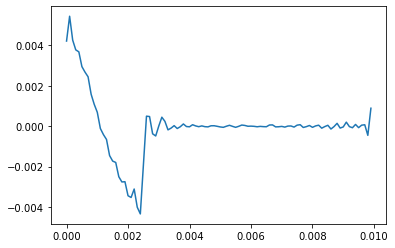

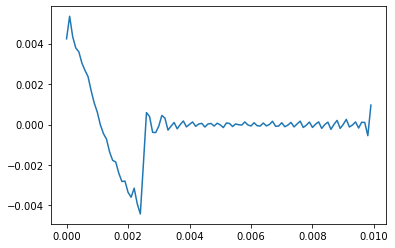

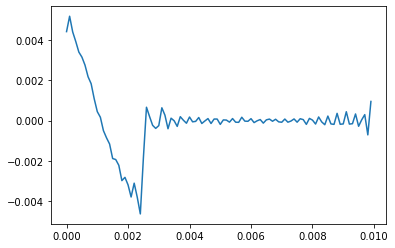

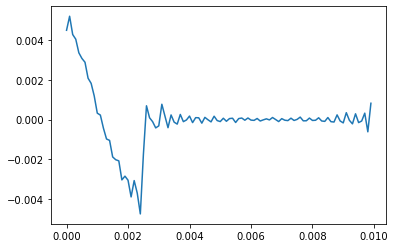

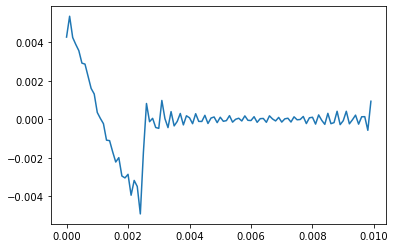

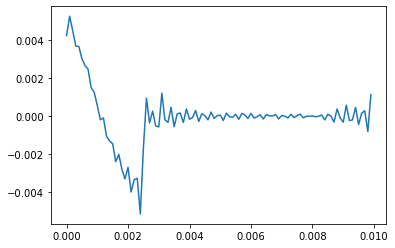

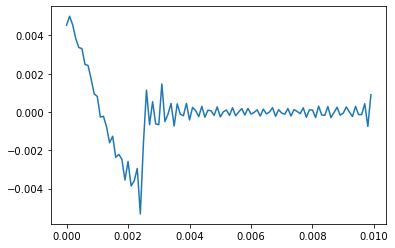

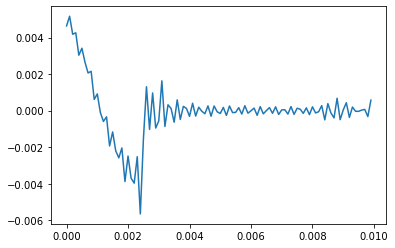

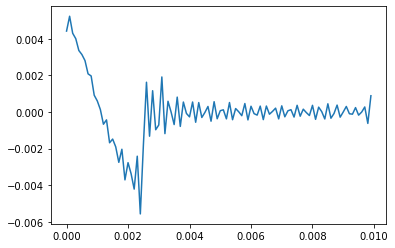

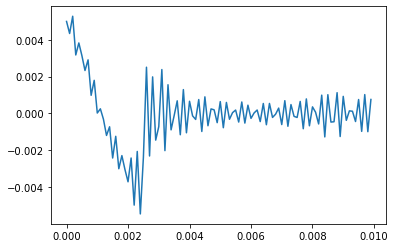

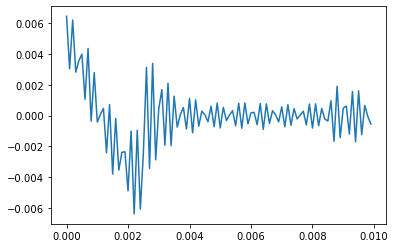

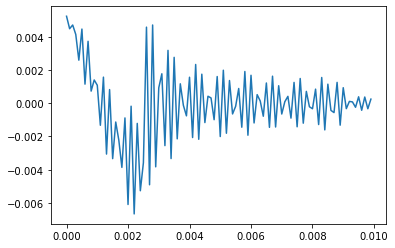

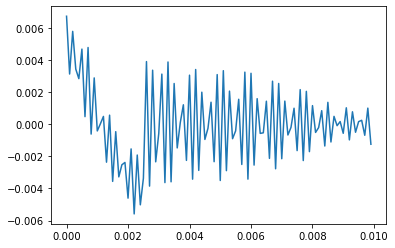

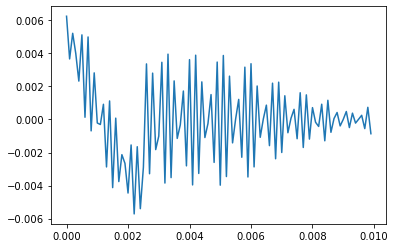

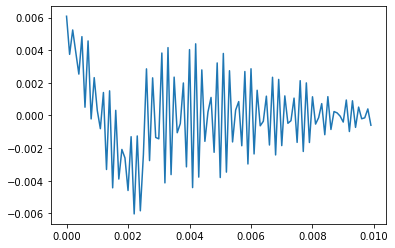

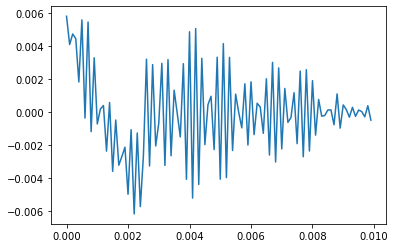

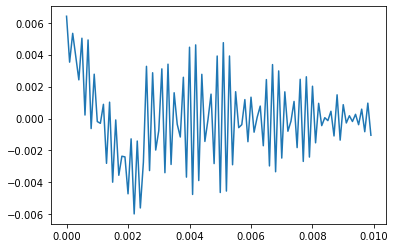

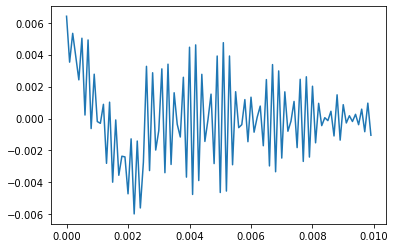

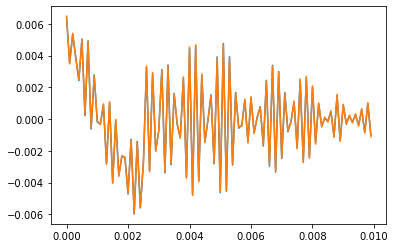

In [8]:
df = pd.DataFrame({"frequency":pos_freq,"amplitude":pos_signal_fft,"phase":pos_phase})
top_funcions = df #.sort_values(by="amplitude",ascending=False) #.head(25)
#print(top_funcions)
t = np.array(data["t"][:n])
sub_functions = []
reconstructed = np.zeros(len(t))
plt.plot(data["t"][:n],data["v"][:n])
plt.show()
for i in range(len(top_funcions)):
    function = 2* top_funcions["amplitude"].iloc[i]/n * np.cos(-(t)*2*math.pi*top_funcions["frequency"].iloc[i]-top_funcions["phase"].iloc[i])
    sub_functions.append([top_funcions["frequency"].iloc[i],top_funcions["amplitude"].iloc[i],top_funcions["phase"].iloc[i]])
    reconstructed+=function
    plt.plot(t,reconstructed)
    plt.show()


plt.plot(t,reconstructed)
plt.show()

plt.plot(t,reconstructed)
plt.plot(data["t"][:n],data["v"][:n])
plt.show()

# plt.plot(data["t"][:n],data["v"][:n]-np.flip(reconstructed))
# plt.show()

In [8]:
output = np.array(sub_functions)[:,1:].reshape(1,len(sub_functions)*2)

In [9]:
def get_result_function(output,t):
    
    """
    This function transforms the output of a neural network, which is in the form of fourier coefficients, into a reconstructed signal.
    Every even element of output is an amplitude, and every odd is a phase of a cosine wave.
    """
    
    
    output = output[0]
    reconstructed = np.zeros(len(t))
    n = len(output)/2
    for i in range(0,len(output),2):
        freq = sampling_rate/(4*n) * i
        function =  output[i]/n  *  np.cos(-(t)*2*math.pi*freq-output[i+1]) #* np.exp(-100*t)
        reconstructed += function
    return reconstructed

In [10]:
true_result = get_result_function(output,t)

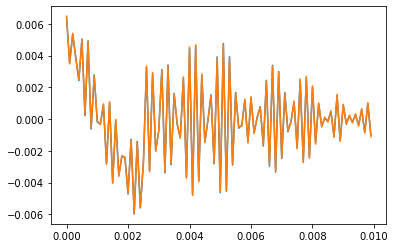

In [11]:
plt.plot(t,true_result)
plt.plot(t,data["v"][:100])
plt.show()

# Training

We train the model on 1 signal to see how well it can approximate it. In model1, we train directly, comparing model output to parameters we got from the Fourier transform.

In [12]:
X = torch.tensor(np.array(sim1["metadata"])).to(device).to(torch.float64)
Y = torch.tensor(output).to(device).to(torch.float64)

In [13]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 100)
        self.double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
model1 = NN().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [15]:
epochs = 200
batch_size = 1
data_loader = DataLoader(list(zip(X,Y)),batch_size=1, shuffle=False)

Epoch [0/200], Loss: 0.9282839576526982


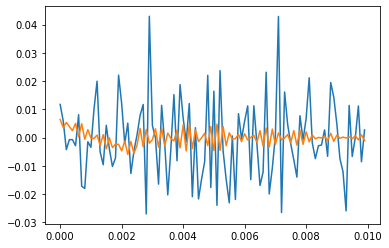

Epoch [10/200], Loss: 0.21863328884288508


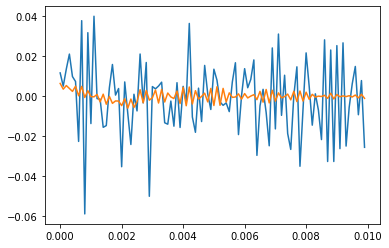

Epoch [20/200], Loss: 0.03576825731186053


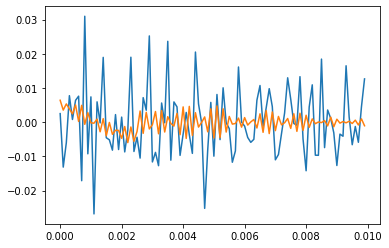

Epoch [30/200], Loss: 0.01365629901647366


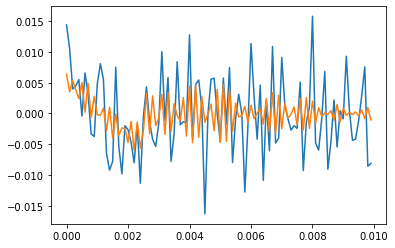

Epoch [40/200], Loss: 0.004953310439278064


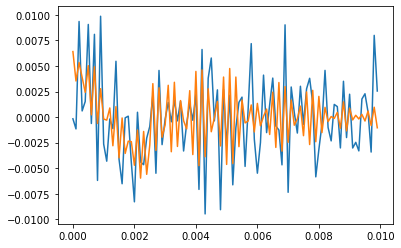

Epoch [50/200], Loss: 0.0013137778330700517


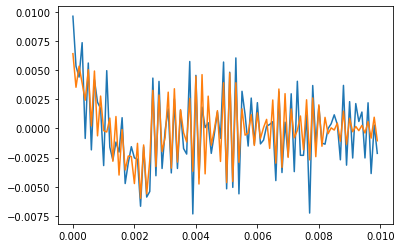

Epoch [60/200], Loss: 0.0006278159340551713


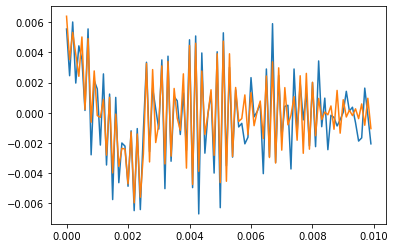

Epoch [70/200], Loss: 0.00018522688777021414


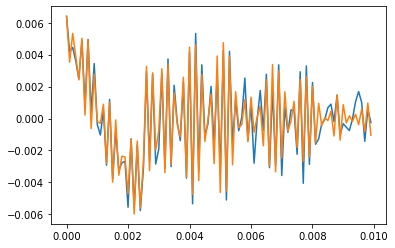

Epoch [80/200], Loss: 7.167798217168977e-05


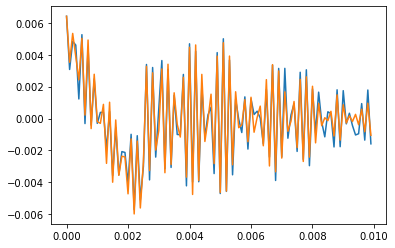

Epoch [90/200], Loss: 2.4091308916794143e-05


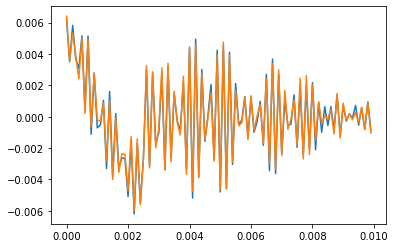

Epoch [100/200], Loss: 7.882342755712647e-06


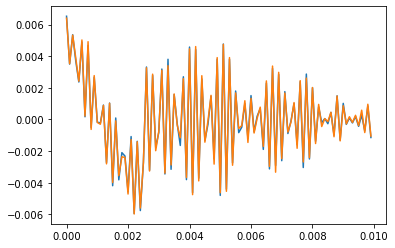

Epoch [110/200], Loss: 3.7609748110819685e-06


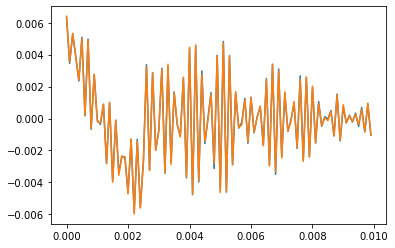

Epoch [120/200], Loss: 1.0373563305972827e-06


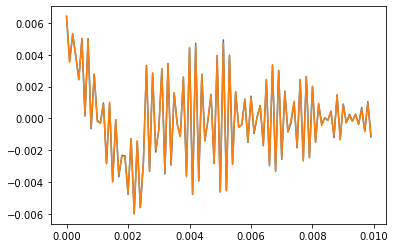

Epoch [130/200], Loss: 4.7159437127280086e-07


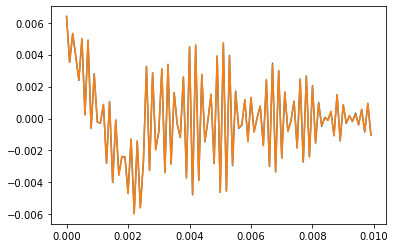

Epoch [140/200], Loss: 1.1600511726962656e-07


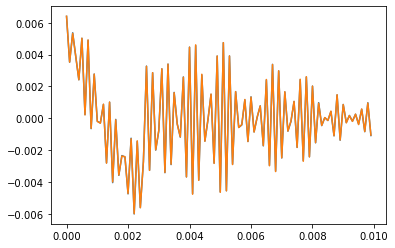

Epoch [150/200], Loss: 5.681582767429255e-08


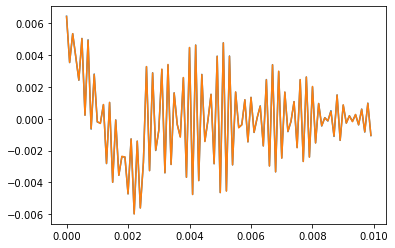

Epoch [160/200], Loss: 1.965142900152973e-08


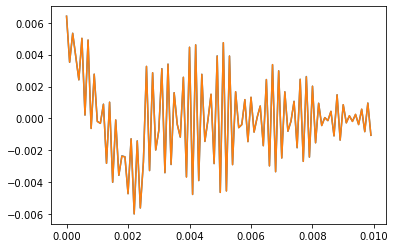

Epoch [170/200], Loss: 6.6600956455293366e-09


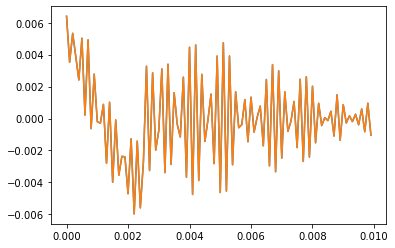

Epoch [180/200], Loss: 2.17362820202386e-09


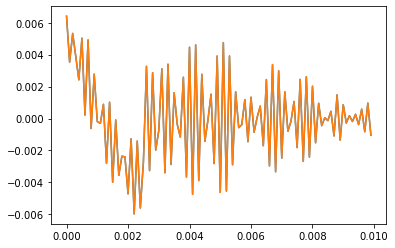

Epoch [190/200], Loss: 1.0056490326468445e-09


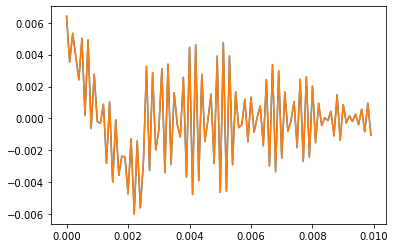

In [17]:
loss_log_1 = pd.DataFrame({"Epoch":[],"Loss":[]})
for epoch in range(epochs):
    running_loss = 0.0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model1(x)
        loss = loss_fn(outputs, y)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if epoch%10 ==0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss}')
        
        new_row = {'Epoch': epoch, 'Loss': running_loss}
        loss_log_1.loc[len(loss_log_1)] = new_row
        
        pred = np.array(model1(X).cpu().detach())
        result = get_result_function(pred,t)
        plt.plot(t,result)
        plt.plot(t,true_result)
        plt.show()


In [18]:
aplitudes1 = []
phases1 = [] 
for i in range(0,100,2):
    aplitudes1.append(pred[0][i])
    phases1.append(pred[0][i+1])

# Alternative loss calculations

In [186]:
t = np.array(data["t"][:n])

In [187]:
def loss_curve(y_true,y_pred,t,loss_fn=nn.MSELoss()):
    
    """
    This function calculates loss by first reconstructing the signal from Fourier series parameters.
    """
    
    n = len(y_true)/2
    true_reconstructed = torch.zeros_like(t)  
    pred_reconstructed = torch.zeros_like(t)

    for i in range(0, len(y_true), 2):
        freq = 50 * i
        
        true_function =  y_true[i] / n * torch.cos(-(t) * 2 * torch.pi * freq - y_true[i + 1])
        true_reconstructed+=true_function

        pred_function =  y_pred[i] / n * torch.cos(-(t) * 2 * torch.pi * freq - y_pred[i + 1])
        pred_reconstructed+=pred_function
    
    return loss_fn(true_reconstructed,pred_reconstructed)
        
    

In [188]:
epochs = 200
batch_size = 1
data_loader = DataLoader(list(zip(X,Y)),batch_size=1, shuffle=False)

In [189]:
model2 = NN().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
t_tensor = torch.tensor(t).to(device)

Epoch [0/200], Loss: 0.00025266411391185916


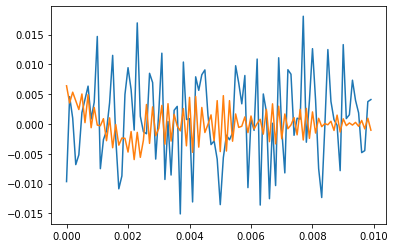

Epoch [10/200], Loss: 8.116696827568468e-06


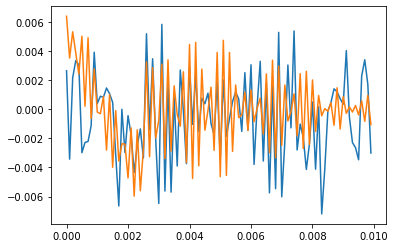

Epoch [20/200], Loss: 3.773405324202802e-06


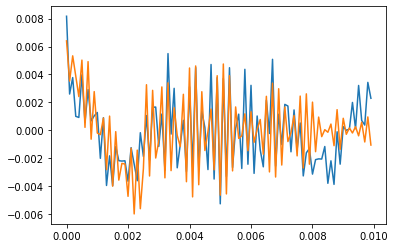

Epoch [30/200], Loss: 2.511454763077473e-06


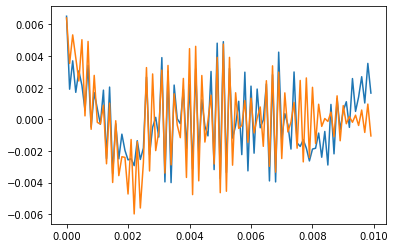

Epoch [40/200], Loss: 2.259744123953184e-06


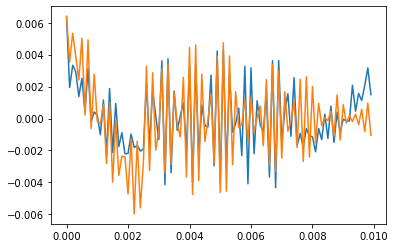

Epoch [50/200], Loss: 2.047537242957362e-06


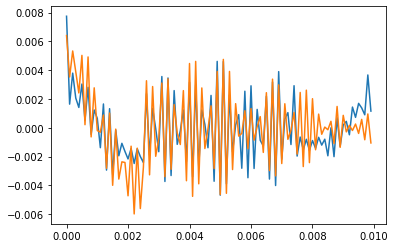

Epoch [60/200], Loss: 1.901133930137253e-06


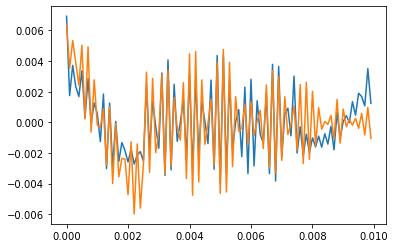

Epoch [70/200], Loss: 1.7815918200796008e-06


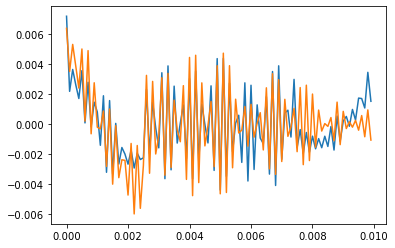

Epoch [80/200], Loss: 1.6638002578107654e-06


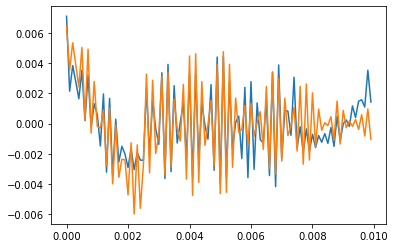

Epoch [90/200], Loss: 1.549365108505275e-06


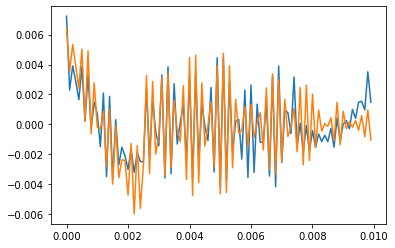

Epoch [100/200], Loss: 1.4321502319794664e-06


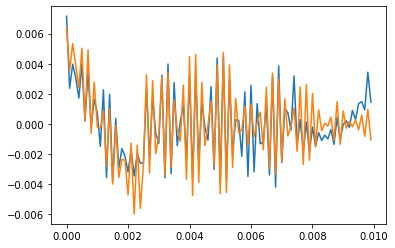

Epoch [110/200], Loss: 1.31268793050855e-06


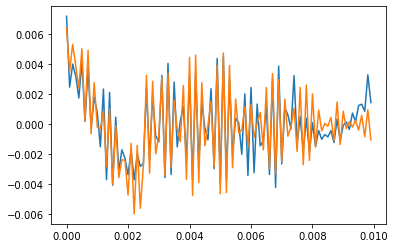

Epoch [120/200], Loss: 1.1911825304689059e-06


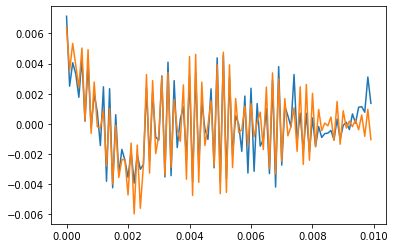

Epoch [130/200], Loss: 1.0716396274104642e-06


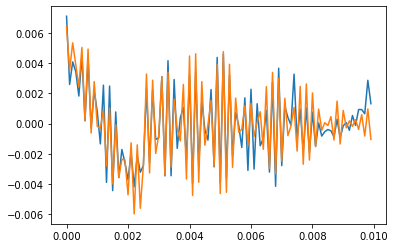

Epoch [140/200], Loss: 9.532532014030595e-07


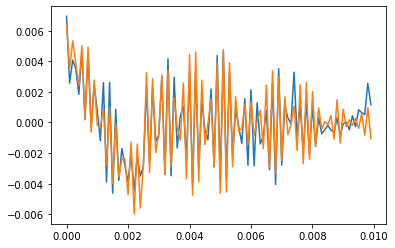

Epoch [150/200], Loss: 8.35836804019999e-07


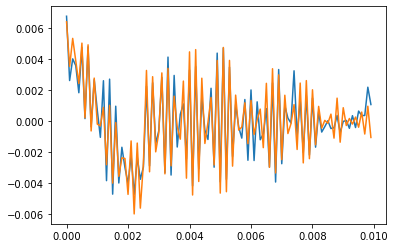

Epoch [160/200], Loss: 7.158685502751323e-07


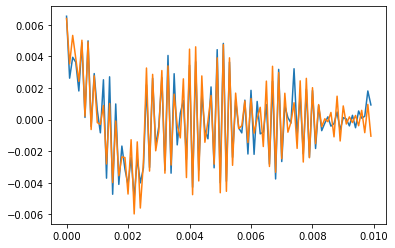

Epoch [170/200], Loss: 5.892502659026489e-07


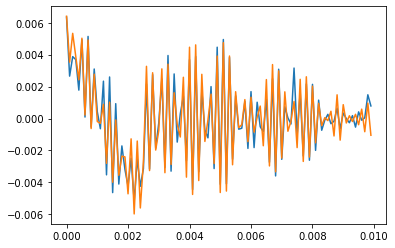

Epoch [180/200], Loss: 4.583347911832124e-07


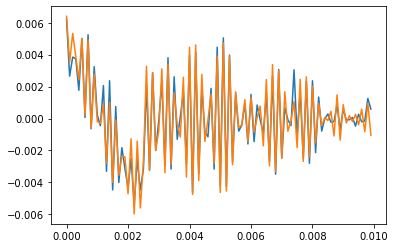

Epoch [190/200], Loss: 3.36012907288802e-07


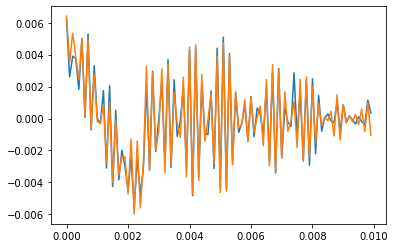

Epoch [200/200], Loss: 2.397715351946414e-07


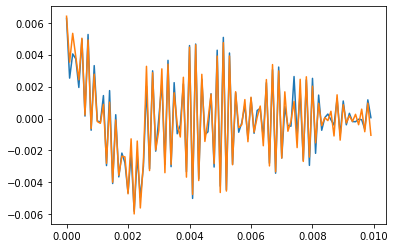

In [190]:
loss_log_2 = pd.DataFrame({"Epoch":[],"Loss":[]})
for epoch in range(epochs+1):
    running_loss = 0.0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model2(x)
        loss = loss_curve(outputs[0], y[0],t_tensor)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        new_row = {'Epoch': epoch, 'Loss': running_loss}
        loss_log_2.loc[len(loss_log_2)] = new_row 
    if epoch%10 ==0 or epoch==epochs :
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss}')
        
        pred = np.array(model2(X).cpu().detach())
        result = get_result_function(pred,t)
        plt.plot(t,result)
        plt.plot(t,true_result)
        plt.show()


In [131]:
aplitudes2 = []
phases2 = [] 
for i in range(0,100,2):
    aplitudes2.append(pred[0][i])
    phases2.append(pred[0][i+1])

In [132]:
aplitudes0 = []
phases0 = [] 
for i in range(0,100,2):
    aplitudes0.append(np.array(Y[0][i].cpu()))
    phases0.append(Y[0][i+1].cpu())

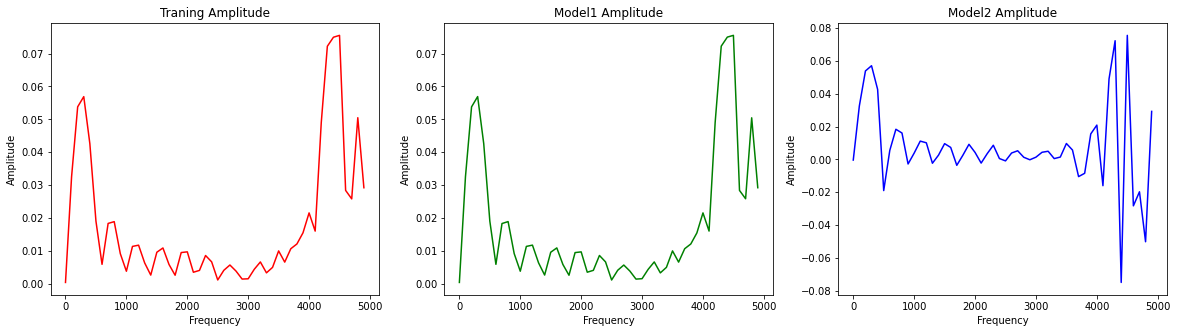

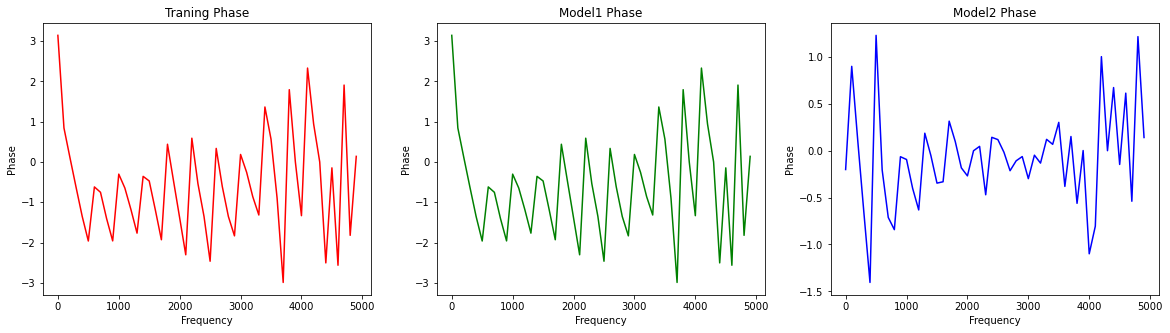

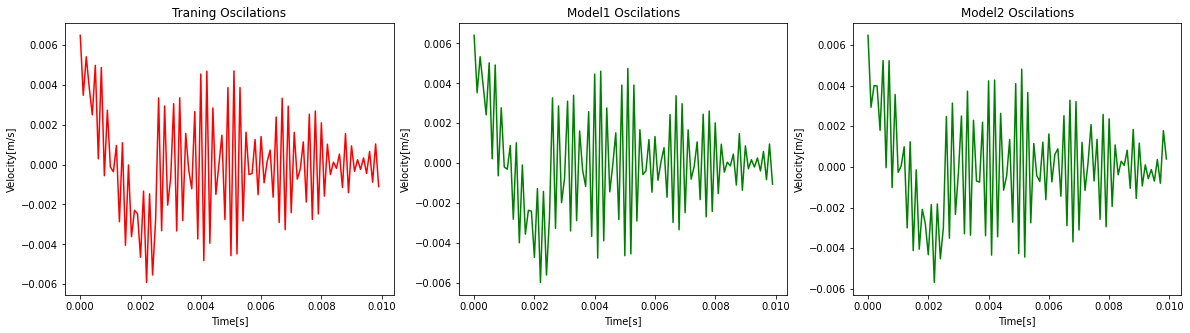

In [133]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))


axs[0].plot(np.linspace(0,4900,50),aplitudes0,c='red')
axs[0].set_title(f'Traning Amplitude')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Amplitude')

axs[1].plot(np.linspace(0,4900,50),aplitudes1,c='green')
axs[1].set_title(f'Model1 Amplitude')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Amplitude')

axs[2].plot(np.linspace(0,4900,50),aplitudes2,c='blue')
axs[2].set_title(f'Model2 Amplitude')
axs[2].set_xlabel('Frequency')
axs[2].set_ylabel('Amplitude')

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(np.linspace(0,4900,50),phases0,c='red')
axs[0].set_title(f'Traning Phase')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Phase')

axs[1].plot(np.linspace(0,4900,50),phases1,c='green')
axs[1].set_title(f'Model1 Phase')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Phase')

axs[2].plot(np.linspace(0,4900,50),phases2,c='blue')
axs[2].set_title(f'Model2 Phase')
axs[2].set_xlabel('Frequency')
axs[2].set_ylabel('Phase')

plt.show()


fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(data['t'][:100],data['v'][:100],c='red')
axs[0].set_title(f'Traning Oscilations')
axs[0].set_xlabel('Time[s]')
axs[0].set_ylabel('Velocity[m/s]')

result1 = get_result_function(np.array(model1(X).detach().cpu()),t)
axs[1].plot(data['t'][:100],result1,c='green')
axs[1].set_title(f'Model1 Oscilations')
axs[1].set_xlabel('Time[s]')
axs[1].set_ylabel('Velocity[m/s]')

result2 = get_result_function(np.array(model2(X).detach().cpu()),t)
axs[2].plot(data['t'][:100],result2,c='green')
axs[2].set_title(f'Model2 Oscilations')
axs[2].set_xlabel('Time[s]')
axs[2].set_ylabel('Velocity[m/s]')
plt.show()


This graph shows how model 2 finds alternative Fourier series parameters, but the reconstructed signal is still close to training data.

# PINN

We try to incorporate some physical knowledge by adding a damping factor to the Fourier series.

In [209]:
function_amount = 50

In [210]:
v = torch.tensor(np.array(data["v"][:100])).to(device)
t = torch.tensor(np.array(data["t"][:100])).to(device)

In [211]:
#v = 0*t

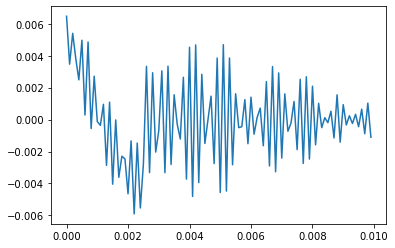

In [212]:
plt.plot(t.cpu(),v.cpu())

In [213]:
class PINN(nn.Module):
    def __init__(self,function_amount):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, function_amount*3)
        self.double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [214]:
def get_damped_result(t,Dy_pred):
    """
    This function returns a reconstructed signal based on different aplitudes, phases, and damping factors. 
    """
    n = len(y_pred)/3 
    fun_sum = torch.zeros_like(t)
    w_incr = 5000/(len(y_pred)/3)
    for i in range(0, len(y_pred), 3):
        #print(i)
        w = w_incr* i/3
        f =  y_pred[i]/n * torch.exp((-1)*torch.abs(y_pred[i+1])*t) * torch.cos(w*2 * torch.pi*t + y_pred[i+2])
        fun_sum += f
    return fun_sum

In [218]:
model3 = PINN(function_amount)
model3.to(device)
epochs = 200
optimizer = optim.Adam(model3.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

Epoch [0/200], Loss: 0.00010937715133996514


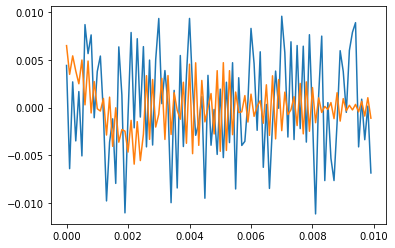

Epoch [10/200], Loss: 5.695117414678621e-06


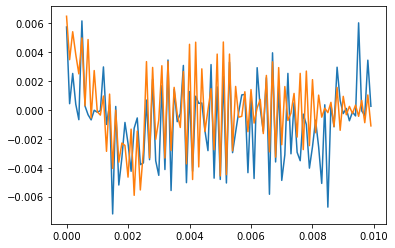

Epoch [20/200], Loss: 3.355478100134055e-06


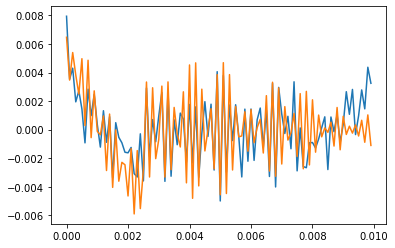

Epoch [30/200], Loss: 2.5752599179334908e-06


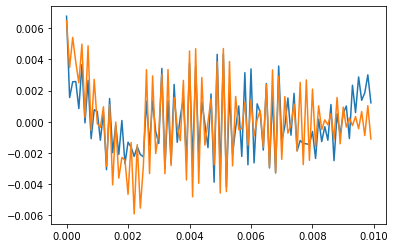

Epoch [40/200], Loss: 2.2158621981058416e-06


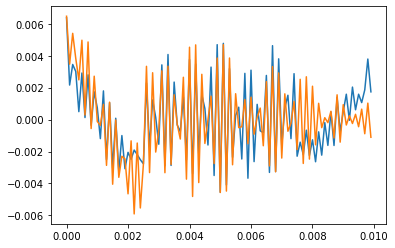

Epoch [50/200], Loss: 2.026957627546304e-06


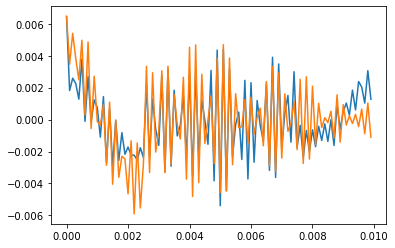

Epoch [60/200], Loss: 1.8613816287058803e-06


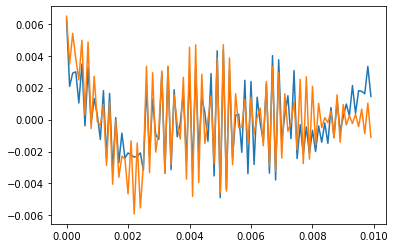

Epoch [70/200], Loss: 1.7184031954396253e-06


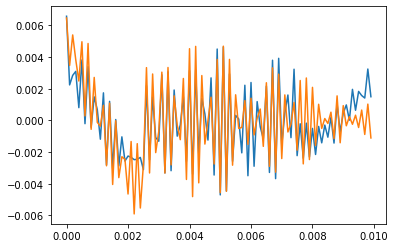

Epoch [80/200], Loss: 1.5696666779361596e-06


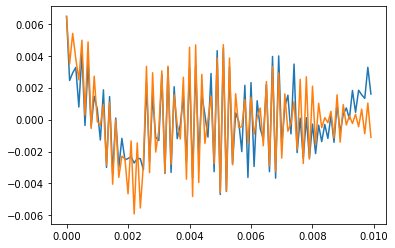

Epoch [90/200], Loss: 1.411592419378721e-06


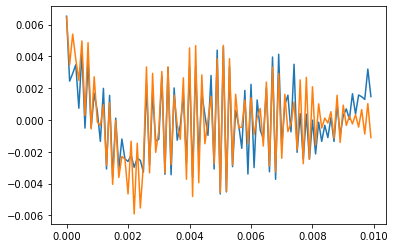

Epoch [100/200], Loss: 1.2386903340572808e-06


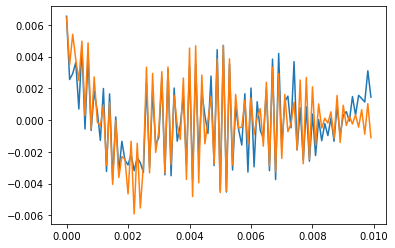

Epoch [110/200], Loss: 1.0524463932642632e-06


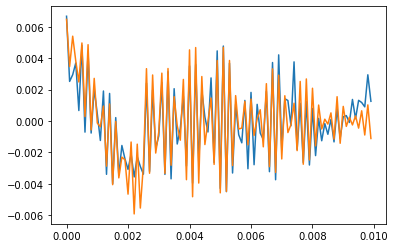

Epoch [120/200], Loss: 8.51184617669535e-07


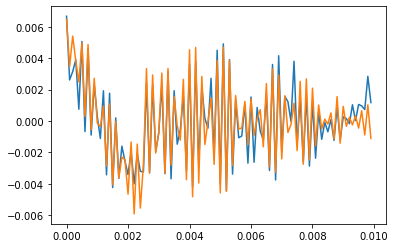

Epoch [130/200], Loss: 6.420992334586008e-07


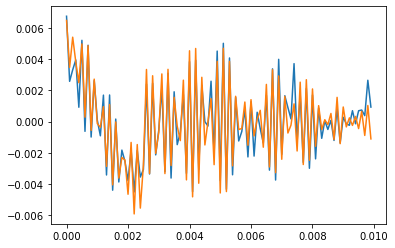

Epoch [140/200], Loss: 4.4889082050295085e-07


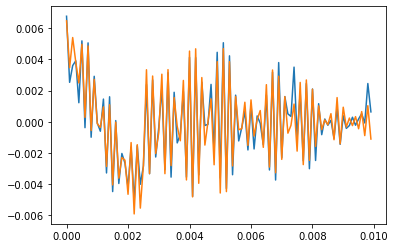

Epoch [150/200], Loss: 3.0108935965996187e-07


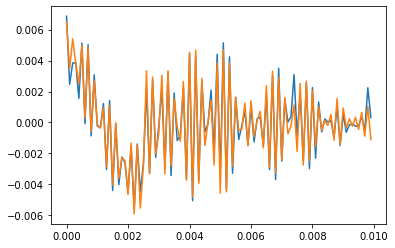

Epoch [160/200], Loss: 2.114840155579565e-07


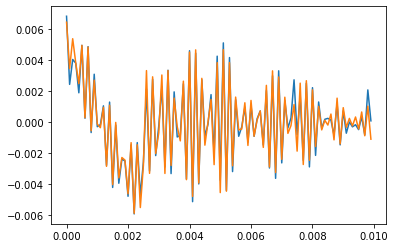

Epoch [170/200], Loss: 1.6488737239741067e-07


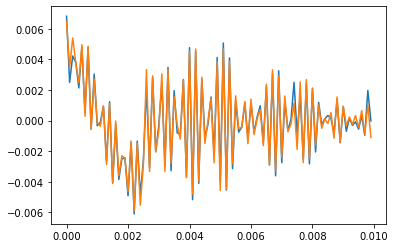

Epoch [180/200], Loss: 1.401221685391406e-07


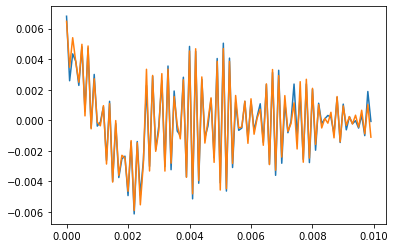

Epoch [190/200], Loss: 1.240947263616788e-07


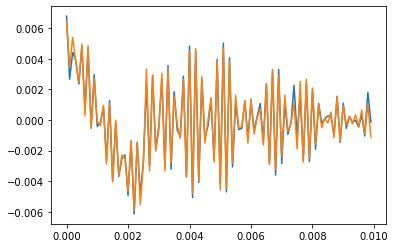

Epoch [200/200], Loss: 1.1184452821553808e-07


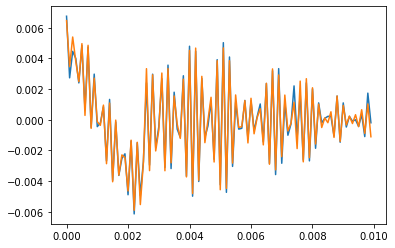

In [219]:
loss_log_3 = pd.DataFrame({"Epoch":[],"Loss":[]})
for epoch in range(epochs+1):
    
    x = X[0].to(device)
    optimizer.zero_grad()
    outputs = model3(x)
    #print(outputs.shape)
    damped_tensor = get_damped_result(t,outputs)
    
    loss = loss_fn(damped_tensor,v)

    loss.backward()
    optimizer.step()

    new_row = {'Epoch': epoch, 'Loss': loss.item()}
    loss_log_3.loc[len(loss_log_3)] = new_row
    if epoch%10 ==0 or epoch==epochs:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss}')
        new_row = {'Epoch': epoch, 'Loss': loss.item()}
        loss_log_3.loc[len(loss_log_3)] = new_row
        pred = model3(X)
        draw = np.array(get_damped_result(t,pred[0]).cpu().detach())
        plt.plot(t.cpu(),draw)
        plt.plot(t.cpu(),v.cpu())
        plt.show()


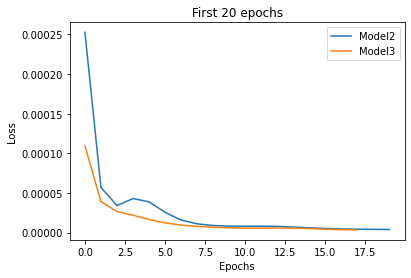

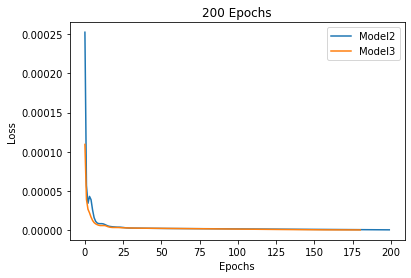

In [220]:
k = 20
plt.plot(loss_log_2["Epoch"][:k],loss_log_2["Loss"][:k],label="Model2")
plt.plot(loss_log_3["Epoch"][:k],loss_log_3["Loss"][:k],label="Model3")
plt.title("First 20 epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

k = 200
plt.title("200 Epochs")
plt.plot(loss_log_2["Epoch"][:k],loss_log_2["Loss"][:k],label="Model2")
plt.plot(loss_log_3["Epoch"][:k],loss_log_3["Loss"][:k],label="Model3")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()